本笔记本为[教材](http://manipulation.csail.mit.edu/pick.html)提供了配套示例。建议将两个窗口并排打开！

In [1]:
# 导入所需库
import mpld3
import numpy as np
from matplotlib import pyplot as plt
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    AngleAxis,
    DiagramBuilder,
    Integrator,
    JacobianWrtVariable,
    LeafSystem,
    MeshcatVisualizer,
    MultibodyPlant,
    MultibodyPositionToGeometryPose,
    Parser,
    PiecewisePolynomial,
    PiecewisePose,
    Quaternion,
    Rgba,
    RigidTransform,
    RotationMatrix,
    SceneGraph,
    Simulator,
    StartMeshcat,
    TrajectorySource,
    )

from manipulation import running_as_notebook
from manipulation.station import LoadScenario, MakeHardwareStation
from manipulation.utils import RenderDiagram

if running_as_notebook:
    mpld3.enable_notebook()

In [2]:
# 启动可视化工具。
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


# 带关键帧的抓取与放置“草图”


首先让我们定义问题中的标准坐标系。我们有好几个坐标系，并且会在多个函数之间传递，所以我会用一个字典来存储它们。


注意：这里我又添加了一个坐标系，用于在箱子之间移动时获得一定的间隙。如果不加这个，会出现一个有趣的[机器人失误](http://manipulation.csail.mit.edu/data/pick_fail.html)。

In [18]:
def MakeGripperFrames(X_WG, X_WO):
    """
    输入部分指定的 X_G["initial"]、X_O["initial"] 和 X_O["goal"]，返回填充好所有抓取与放置关键帧的 X_G 和时间点。
    """
    # （再次）定义夹爪在抓取时相对于物体的位姿。
    p_GgraspO = [0, 0.12, 0]
    R_GgraspO = RotationMatrix.MakeXRotation(
        np.pi / 2.0
) @ RotationMatrix.MakeZRotation(np.pi / 2.0)
    X_GgraspO = RigidTransform(R_GgraspO, p_GgraspO)
    X_OGgrasp = X_GgraspO.inverse()
    # 预抓取是在夹爪坐标系下的负 y 方向（见图！）。
    X_GgraspGpregrasp = RigidTransform([0, -0.08, 0])

    X_WG["pick"] = X_WO["initial"] @ X_OGgrasp
    X_WG["prepick"] = X_WG["pick"] @ X_GgraspGpregrasp
    X_WG["place"] = X_WO["goal"] @ X_OGgrasp
    X_WG["preplace"] = X_WG["place"] @ X_GgraspGpregrasp

    # 通过轴角插值获得中间姿态。
    X_GprepickGpreplace = X_WG["prepick"].inverse() @ X_WG["preplace"]
    angle_axis = X_GprepickGpreplace.rotation().ToAngleAxis()
    X_GprepickGclearance = RigidTransform(
        AngleAxis(angle=angle_axis.angle() / 2.0, axis=angle_axis.axis()),
        X_GprepickGpreplace.translation() / 2.0 + np.array([0, -0.3, 0]),
)
    X_WG["clearance"] = X_WG["prepick"] @ X_GprepickGclearance

    # 设置时间点
    times = {"initial": 0}
    X_GinitialGprepick = X_G["initial"].inverse() @ X_WG["prepick"]
    times["prepick"] = times["initial"] + 10.0 * np.linalg.norm(
        X_GinitialGprepick.translation()
    )
    # 给夹爪闭合预留时间。
    times["pick_start"] = times["prepick"] + 2.0
    times["pick_end"] = times["pick_start"] + 2.0
    X_WG["pick_start"] = X_WG["pick"]
    X_WG["pick_end"] = X_WG["pick"]
    times["postpick"] = times["pick_end"] + 2.0
    X_WG["postpick"] = X_WG["prepick"]
    time_to_from_clearance = 10.0 * np.linalg.norm(X_GprepickGclearance.translation())
    times["clearance"] = times["postpick"] + time_to_from_clearance
    times["preplace"] = times["clearance"] + time_to_from_clearance
    times["place_start"] = times["preplace"] + 2.0
    times["place_end"] = times["place_start"] + 2.0
    X_WG["place_start"] = X_WG["place"]
    X_WG["place_end"] = X_WG["place"]
    times["postplace"] = times["place_end"] + 2.0
    X_WG["postplace"] = X_WG["preplace"]

    return X_WG, times

# 初始夹爪和物体位姿
X_G = {
    "initial": RigidTransform(
        RotationMatrix.MakeXRotation(-np.pi / 2.0), [0, -0.25, 0.25]
    )
}
X_O = {
    "initial": RigidTransform(
        RotationMatrix.MakeZRotation(np.pi / 2.0), [-0.2, -0.75, 0.025]
    ),
    "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi), [0.75, 0, 0.025]),
}
X_G, times = MakeGripperFrames(X_G, X_O)
print(
    f"健全性检查：整个操作将耗时 {times['postplace']} 秒。"
 )

健全性检查：整个操作将耗时 30.900220749318255 秒。


下面是这些关键帧的简单可视化。使用 meshcat 的控制菜单可以查看不同路径下的对象，理解每个对象属于哪个坐标系。看起来都合理吗？


试着修改夹爪/物体的初始和最终位姿。

In [21]:
def visualize_gripper_frames(X_G, X_O):
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    parser = Parser(plant, scene_graph)
    parser.SetAutoRenaming(True)
    for key, pose in X_G.items():
        g = parser.AddModelsFromUrl(
            "package://drake_models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"
        )[0]
        plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("body", g), pose)
    for key, pose in X_O.items():
        o = parser.AddModelsFromUrl(
            "package://drake_models/manipulation_station/061_foam_brick.sdf"
        )[0]
        plant.WeldFrames(
            plant.world_frame(), plant.GetFrameByName("base_link", o), pose
        )

    plant.Finalize()

    meshcat.Delete()
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.ForcedPublish(context)

# 可视化关键帧
visualize_gripper_frames(X_G, X_O)

# 抓取与放置轨迹


我们已经定义了关键帧，现在需要补充时间细节（每一时刻应该发生什么）。


在位置之间插值很简单；我们可以用 $\Re^3$ 上的 `PiecewisePolynomial` 轨迹来编码这些细节。姿态插值则需要更小心。我们将用 `PiecewiseQuaternionSlerp` 来完成。


更多细节见 [PiecewisePose](https://drake.mit.edu/doxygen_cxx/classdrake_1_1trajectories_1_1_piecewise_pose.html#ae2f8a49b642aecb5c19ef3625be5e61d) 文档。

In [5]:
def MakeGripperPoseTrajectory(X_G, times):
    """
    根据计划“草图”构造夹爪位姿轨迹。
    """

    sample_times = []
    poses = []
    for name in [
        "initial",
        "prepick",
        "pick_start",
        "pick_end",
        "postpick",
        "clearance",
        "preplace",
        "place_start",
        "place_end",
        "postplace",
    ]:
        sample_times.append(times[name])
        poses.append(X_G[name])

    return PiecewisePose.MakeLinear(sample_times, poses)

# 生成夹爪位姿轨迹
traj_X_G = MakeGripperPoseTrajectory(X_G, times)

现在让我们绘制轨迹。

In [6]:
traj_p_G = traj_X_G.get_position_trajectory()

p_G = traj_p_G.vector_values(traj_p_G.get_segment_times())
plt.plot(traj_p_G.get_segment_times(), p_G.T)
plt.legend(["x", "y", "z"])
plt.title("p_G 位置轨迹")
mpld3.display()

/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 36857 (\N{CJK UNIFIED IDEOGRAPH-8FF9}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)


我们还可以直接在 Meshcat 中以 3D 方式绘制轨迹。

In [22]:
meshcat.ResetRenderMode()
meshcat.SetLine("p_G", p_G, 2.0, rgba=Rgba(1, 0.65, 0))

我们也可以绘制姿态轨迹。下面是四元数分量随时间的变化。

In [23]:
traj_R_G = traj_X_G.get_orientation_trajectory()
R_G = traj_R_G.vector_values(traj_R_G.get_segment_times())
plt.plot(traj_R_G.get_segment_times(), R_G.T)
plt.legend(["qx", "qy", "qz", "qw"])
plt.title("R_G 四元数轨迹")
mpld3.display()

/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 22235 (\N{CJK UNIFIED IDEOGRAPH-56DB}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)


其实更好的是直接绘制完整结果。在此之前，先快速定义一下夹爪指令轨迹。

In [24]:
def MakeGripperCommandTrajectory(times):
    opened = np.array([0.107])
    closed = np.array([0.0])

    traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["pick_start"]],
        np.hstack([[opened], [opened]]),
    )
    traj_wsg_command.AppendFirstOrderSegment(times["pick_end"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_start"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_end"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["postplace"], opened)
    return traj_wsg_command

# 生成夹爪指令轨迹
traj_wsg_command = MakeGripperCommandTrajectory(times)

In [25]:
wsg_command = traj_wsg_command.vector_values(traj_wsg_command.get_segment_times())
plt.plot(traj_wsg_command.get_segment_times(), wsg_command.T)
plt.title("wsg_command 夹爪指令轨迹")
mpld3.display()

/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 22841 (\N{CJK UNIFIED IDEOGRAPH-5939}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 29226 (\N{CJK UNIFIED IDEOGRAPH-722A}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 20196 (\N{CJK UNIFIED IDEOGRAPH-4EE4}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)


现在让我们真正可视化轨迹。最好的方式是在 3D 中动画展示！请原谅这段代码有点“定制化”；我想提供一些主流 drake 开发者不常用的中间步骤。


TODO(russt)：让这段代码更通用些。

In [30]:
class GripperTrajectoriesToPosition(LeafSystem):
    def __init__(self, plant, traj_p_G, traj_R_G, traj_wsg_command):
        LeafSystem.__init__(self)
        self.plant = plant
        self.gripper_body = plant.GetBodyByName("body")
        self.left_finger_joint = plant.GetJointByName("left_finger_sliding_joint")
        self.right_finger_joint = plant.GetJointByName("right_finger_sliding_joint")
        self.traj_p_G = traj_p_G
        self.traj_R_G = traj_R_G
        self.traj_wsg_command = traj_wsg_command
        self.plant_context = plant.CreateDefaultContext()

        self.DeclareVectorOutputPort(
            "position", plant.num_positions(), self.CalcPositionOutput
        )

    def CalcPositionOutput(self, context, output):
        t = context.get_time()
        X_G = RigidTransform(Quaternion(self.traj_R_G.value(t)), self.traj_p_G.value(t))
        self.plant.SetFreeBodyPose(self.plant_context, self.gripper_body, X_G)
        wsg = self.traj_wsg_command.value(t)[0, 0]
        self.left_finger_joint.set_translation(self.plant_context, -wsg / 2.0)
        self.right_finger_joint.set_translation(self.plant_context, wsg / 2.0)
        output.SetFromVector(self.plant.GetPositions(self.plant_context))

# 可视化抓取与放置轨迹
def visualize_pick_and_place_trajectory(traj_p_G, traj_R_G, traj_wsg_command, X_O):
    builder = DiagramBuilder()

    # 注意：不要用 AddMultibodyPlantSceneGraph，因为这里只用 MultibodyPlant 解析模型，直接连接到 SceneGraph。
    scene_graph = builder.AddSystem(SceneGraph()) 
    plant = MultibodyPlant(time_step=0.0) # 创建 MultibodyPlant
    plant.RegisterAsSourceForSceneGraph(scene_graph) # 注册 plant 作为 scene_graph 的源
    parser = Parser(plant, scene_graph)
    parser.SetAutoRenaming(True)
    gripper = parser.AddModelsFromUrl(
        "package://drake_models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"
    )[0] 
    brick = "package://drake_models/manipulation_station/061_foam_brick.sdf"
    for key, pose in X_O.items(): # 添加物体模型
        o = parser.AddModelsFromUrl(brick)[0]
        plant.WeldFrames(
            plant.world_frame(), plant.GetFrameByName("base_link", o), pose
        )
    plant.Finalize()

    to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant))
    builder.Connect(
        to_pose.get_output_port(),
        scene_graph.get_source_pose_port(plant.get_source_id()),
    )

    traj_to_position = builder.AddSystem(
        GripperTrajectoriesToPosition(plant, traj_p_G, traj_R_G, traj_wsg_command)
    )
    builder.Connect(traj_to_position.get_output_port(), to_pose.get_input_port())

    meshcat.Delete()
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()

    simulator = Simulator(diagram)
    meshcat.StartRecording(set_visualizations_while_recording=False)
    simulator.AdvanceTo(traj_p_G.end_time() if running_as_notebook else 0.1)
    meshcat.PublishRecording()

# 动画展示轨迹
visualize_pick_and_place_trajectory(traj_p_G, traj_R_G, traj_wsg_command, X_O)

# 汇总所有内容


在上面的可视化中，我们动画展示了计划，但实际上并没有控制机器人！现在让我们把抓取轨迹和基于雅可比的控制器结合起来。


你可能注意到，雅可比控制器的输入是空间速度。但目前我们只有位置和姿态轨迹。我们需要对它们求导得到速度。

In [31]:
traj_v_G = traj_p_G.MakeDerivative()

v_G = traj_v_G.vector_values(traj_v_G.get_segment_times())
plt.plot(traj_v_G.get_segment_times(), v_G.T)
plt.legend(["vx", "vy", "vz"])
plt.title("v_G 速度轨迹")
mpld3.display()

/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 36895 (\N{CJK UNIFIED IDEOGRAPH-901F}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
/home/lvxiangyu11/miniconda3/envs/drake/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:47: UserWarning: Glyph 36857 (\N{CJK UNIFIED IDEOGRAPH-8FF9}) missing from font(s) DejaVu Sans.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)


现在我们需要稍作修改的雅可比控制器版本，使其能从输入端口接收空间速度指令。

In [32]:
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()

        self.V_G_port = self.DeclareVectorInputPort("V_WG", 6)
        self.q_port = self.DeclareVectorInputPort("iiwa.position", 7)
        self.DeclareVectorOutputPort("iiwa.velocity", 7, self.CalcOutput)
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def CalcOutput(self, context, output):
        V_G = self.V_G_port.Eval(context)
        q = self.q_port.Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context,
            JacobianWrtVariable.kV,
            self._G,
            [0, 0, 0],
            self._W,
            self._W,
        )
        J_G = J_G[:, self.iiwa_start : self.iiwa_end + 1]  # 只保留 iiwa 相关部分。
        v = np.linalg.pinv(J_G).dot(V_G)
        output.SetFromVector(v)

哦，时刻到了。激动吗？让我们开始吧！

In [33]:
# 设置物体初始和目标位姿
X_O = {
    "initial": RigidTransform(
        RotationMatrix.MakeZRotation(np.pi / 2.0), [0, -0.6, 0.0]
    ),
    "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi), [0.5, 0, 0.0]),
}

meshcat.Delete()
builder = DiagramBuilder()

# 定义场景数据
scenario_data = """
directives:
- add_directives:
    file: package://manipulation/clutter.dmd.yaml
- add_model:
    name: foam_brick
    file: package://manipulation/hydro/061_foam_brick.sdf
model_drivers:
    iiwa: !IiwaDriver
      control_mode: position_only
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""

scenario = LoadScenario(data=scenario_data)
station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))
plant = station.GetSubsystemByName("plant")
plant.SetDefaultFreeBodyPose(plant.GetBodyByName("base_link"), X_O["initial"])

# 获取夹爪和物体的初始位姿（由默认 Context 设置）
temp_context = station.CreateDefaultContext()
temp_plant_context = plant.GetMyContextFromRoot(temp_context)
X_G = {
    "initial": plant.EvalBodyPoseInWorld(
        temp_plant_context, plant.GetBodyByName("body")
    )
}
X_O["initial"] = plant.EvalBodyPoseInWorld(
    temp_plant_context, plant.GetBodyByName("base_link")
)
X_G, times = MakeGripperFrames(X_G, X_O)
print(
    f"健全性检查：整个操作将耗时 {times['postplace']} 秒。"
 )

# 生成轨迹
traj = MakeGripperPoseTrajectory(X_G, times)
traj_V_G = traj.MakeDerivative()

V_G_source = builder.AddSystem(TrajectorySource(traj_V_G))
V_G_source.set_name("v_WG")
controller = builder.AddSystem(PseudoInverseController(plant))
controller.set_name("PseudoInverseController")
builder.Connect(V_G_source.get_output_port(), controller.GetInputPort("V_WG"))

integrator = builder.AddSystem(Integrator(7))
integrator.set_name("integrator")
builder.Connect(controller.get_output_port(), integrator.get_input_port())
builder.Connect(integrator.get_output_port(), station.GetInputPort("iiwa.position"))
builder.Connect(
    station.GetOutputPort("iiwa.position_measured"),
    controller.GetInputPort("iiwa.position"),
)

traj_wsg_command = MakeGripperCommandTrajectory(times)
wsg_source = builder.AddSystem(TrajectorySource(traj_wsg_command))
wsg_source.set_name("wsg.command")
builder.Connect(wsg_source.get_output_port(), station.GetInputPort("wsg.position"))

diagram = builder.Build()
diagram.set_name("pick_and_place")

simulator = Simulator(diagram)
context = simulator.get_mutable_context()
station_context = station.GetMyContextFromRoot(context)
integrator.set_integral_value(
    integrator.GetMyContextFromRoot(context),
    plant.GetPositions(
        plant.GetMyContextFromRoot(context),
        plant.GetModelInstanceByName("iiwa"),
    ),
)

diagram.ForcedPublish(context)
meshcat.StartRecording()
simulator.AdvanceTo(traj_p_G.end_time() if running_as_notebook else 0.1)
meshcat.PublishRecording()

健全性检查：整个操作将耗时 26.826891105934223 秒。


我们组装了一个相当复杂的系统图。你理解每个部分的作用了吗？

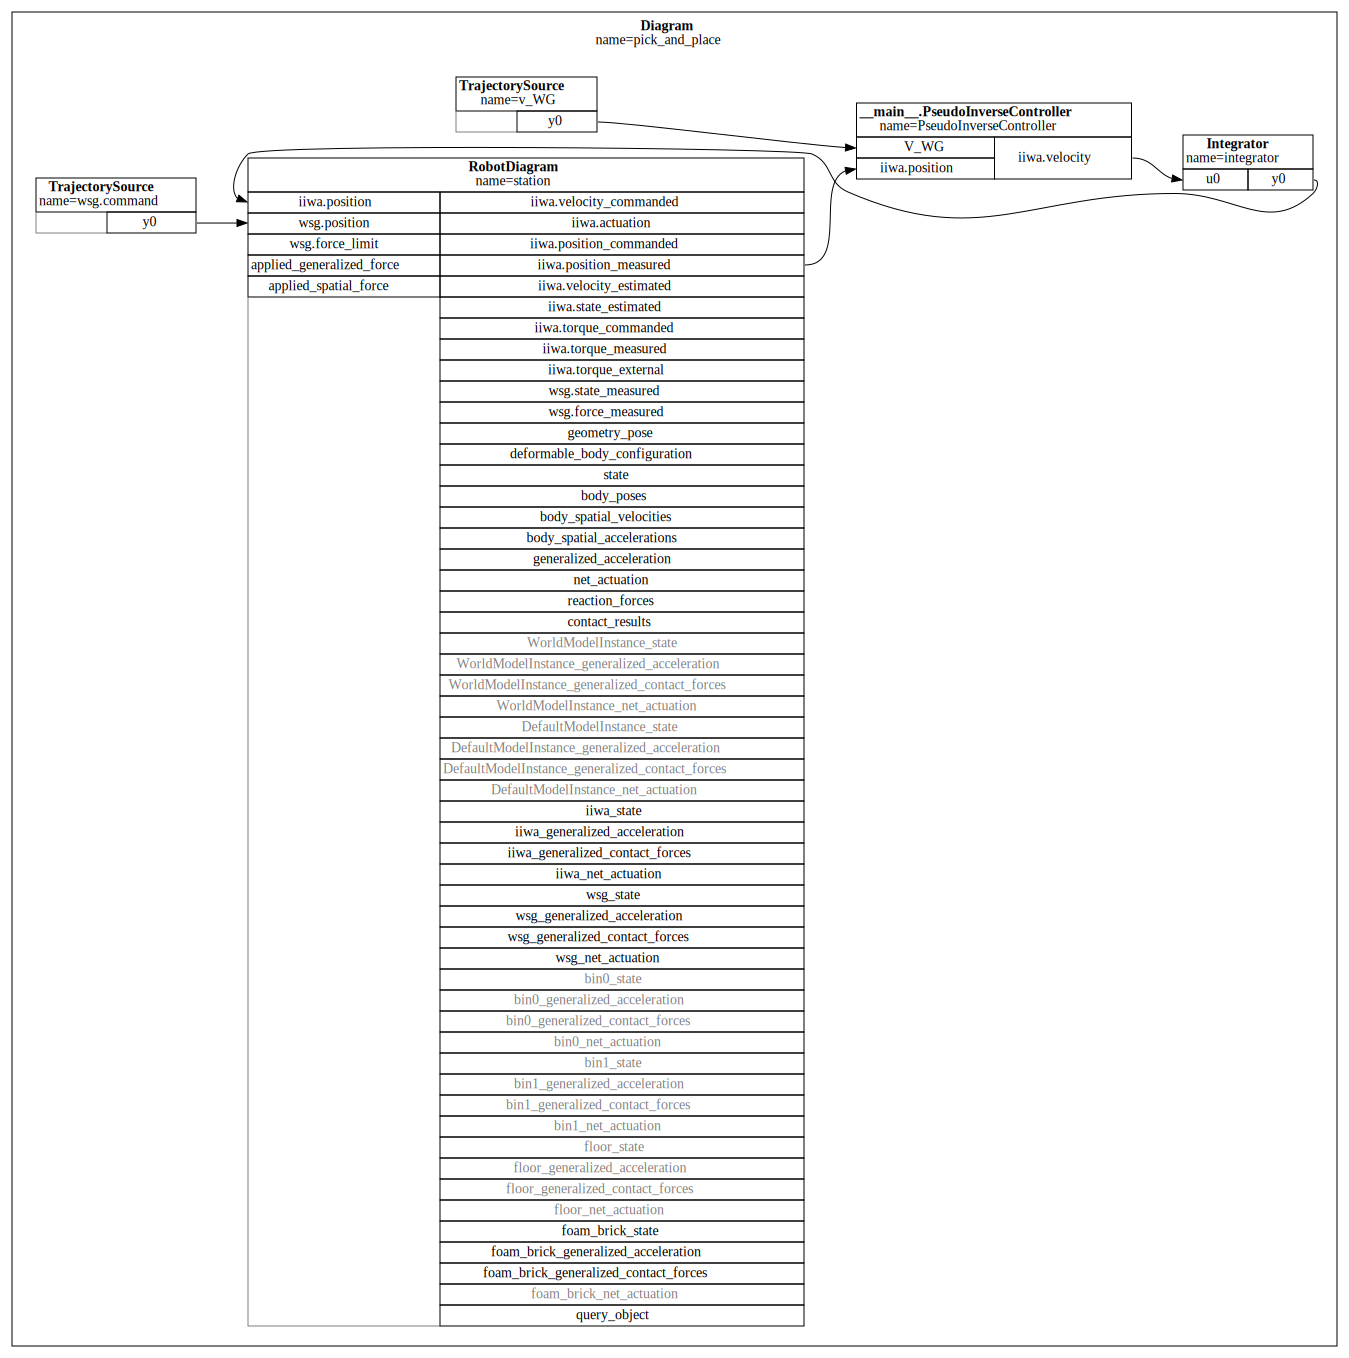

In [15]:
# 渲染系统图
RenderDiagram(diagram, max_depth=1)